In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
!pip install ipywidgets

from ipywidgets import *

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'af48ae6f705f4641b83f410707286679')

In [5]:
from utils import search_images_bing

In [190]:
res = search_images_bing(key, 'leonardo dicaprio cheers')
ims = res.attrgot('contentUrl')
len(ims)

150

In [191]:
ims

(#150) ['https://i.huffpost.com/gen/1194879/thumbs/o-CHEERS-LEONARDO-DICAPRIO-570.jpg?5','https://metrouk2.files.wordpress.com/2016/12/leo-ny.jpg?w=748&h=417&crop=1','https://i.pinimg.com/originals/ac/86/85/ac868572ac98e692e0ad6cfbd3ac8266.jpg','https://media1.tenor.com/images/e7270811b70763cec9d3d3a70d6e2b8c/tenor.gif?itemid=13512186','https://s-media-cache-ak0.pinimg.com/600x315/3b/c4/b6/3bc4b63d964be875419cd216a19e437d.jpg','https://beachgrit.com/wp-content/uploads/2018/09/kisspng-leonardo-dicaprio-jay-gatsby-the-great-gatsby-film-leonardo-dicaprio-5ab68382309d81.1446887215219106581991.jpg','https://media2.s-nbcnews.com/j/streams/2013/june/130617/6c7911379-tdy-130617-leo-toasts-3.nbcnews-ux-2880-1000.jpg','https://media1.tenor.com/images/569b244c394bb50d0f698b47ab8a6edc/tenor.gif?itemid=9439890','http://cache.winetimes.co/wp-content/blogs.dir/1/files/2014/01/leo-cheers.jpg','https://i.pinimg.com/originals/7f/60/46/7f6046c2151e085d1039276dc8fc0850.gif'...]

In [194]:
dest = 'images/dicaprio_cheers.jpg'
download_url(ims[2], dest)

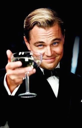

In [195]:
im = Image.open(dest)
im.to_thumb(128,128)

In [18]:
bus_types = 'danfo bus', 'keke napep', 'brt bus', 'molue bus', 'korope bus'
path = Path('Lagos_Transport')

In [19]:
if not path.exists():
    path.mkdir()
    for bus in bus_types:
        dest = (path/bus)
        dest.mkdir(exist_ok=True)
        res = search_images_bing(key, bus)
        download_images(dest, urls=res.attrgot('contentUrl'))

In [21]:
fn = get_image_files(path)

In [22]:
fn

(#674) [Path('Lagos_Transport/molue bus/00000047.jpg'),Path('Lagos_Transport/molue bus/00000107.jpg'),Path('Lagos_Transport/molue bus/00000036.jpg'),Path('Lagos_Transport/molue bus/00000030.jpg'),Path('Lagos_Transport/molue bus/00000148.jpg'),Path('Lagos_Transport/molue bus/00000110.jpg'),Path('Lagos_Transport/molue bus/00000029.jpg'),Path('Lagos_Transport/molue bus/00000112.jpg'),Path('Lagos_Transport/molue bus/00000091.jpg'),Path('Lagos_Transport/molue bus/00000093.jpg')...]

In [23]:
failed = verify_images(fn)
failed

(#28) [Path('Lagos_Transport/molue bus/00000016.jpg'),Path('Lagos_Transport/molue bus/00000138.jpg'),Path('Lagos_Transport/keke napep/00000091.jpg'),Path('Lagos_Transport/keke napep/00000093.jpg'),Path('Lagos_Transport/keke napep/00000035.jpg'),Path('Lagos_Transport/keke napep/00000063.jpg'),Path('Lagos_Transport/keke napep/00000140.jpg'),Path('Lagos_Transport/keke napep/00000118.jpeg'),Path('Lagos_Transport/keke napep/00000051.jpg'),Path('Lagos_Transport/keke napep/00000141.jpg')...]

In [24]:
failed.map(Path.unlink)

(#28) [None,None,None,None,None,None,None,None,None,None...]

In [130]:
buses = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [131]:
buses = buses.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = buses.dataloaders(path)

In [132]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.449591,1.908319,0.702703,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.124470,0.633473,0.297297,00:06
1,0.863227,0.470124,0.162162,00:06
2,0.680440,0.456285,0.162162,00:07
3,0.549102,0.419500,0.135135,00:07


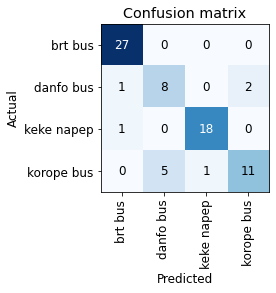

In [133]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

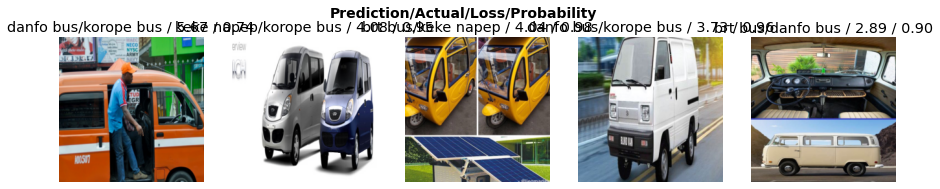

In [134]:
interp.plot_top_losses(5, nrows=1)

In [135]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [129]:
for i in cleaner.delete(): cleaner.fns[i].unlink()
for i, c in cleaner.change(): shutil.move(str(cleaner.fns[i]),path/c)

In [136]:
learn.export()

In [139]:
path= Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [140]:
learn_inf = load_learner(path/'export.pkl')

In [141]:
learn_inf.predict('images/danfo.jpg')

('danfo bus',
 tensor(1),
 tensor([3.2931e-06, 9.9775e-01, 1.5419e-03, 7.0070e-04]))

In [142]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [143]:
img = PILImage.create(btn_upload.data[-1])

In [145]:
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

Output()

In [146]:
with out_pl: display(img.to_thumb(128,128))

In [147]:
pred, pred_idx, probs = learn_inf.predict(img)

In [150]:
lbl_pred = widgets.Label()
lbl_pred.value = f'The image was predicted to be a {pred.title()}, with a probability of {probs[pred_idx]:.04f}'
lbl_pred

Label(value='The image was predicted to be a Keke Napep, with a probability of 0.9998')

In [151]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [152]:
def onClickClassify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_id, probs = learn_inf.predict(img)
    lbl_pred.value = f'The image was predicted to be a {pred.title()}, with a probability of {probs[pred_idx]:.04f}'
    
btn_run.on_click(onClickClassify)